## Introduction
![autobot](../images/autobot.jpg)
Getting the 16x16 patches required for the Visual Transformer (ViT) is not that straight forward. This tutorial demonstrates how to use the `unfold` function in combination with `reshape` to get the required shape of data.

In [2]:
from typing import List

import matplotlib.pyplot as plt
from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image

%matplotlib inline

Let's break up our image of size 256 x 256 into 64 x 64 patches. We should end up with 4 rows and 4 columns of these patches.

In [3]:
IMG_SIZE = 256
PATCH_SIZE = 64

resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
img = resize(io.read_image("../images/autobot.jpg"))

The actual image looks like so:

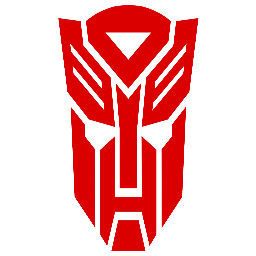

In [4]:
to_pil_image(img)

The `unfold` function can be used to grab a patch of certain size and stride. Unfortunately, you need to use it twice along relevant dimension to get what we are after.

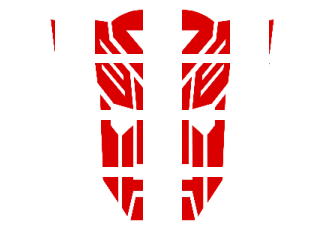

In [5]:
patches = img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)

fig, ax = plt.subplots(4, 4)
for i in range(4):
    for j in range(4):
        sub_img = patches[:, i, j]
        ax[i][j].imshow(to_pil_image(sub_img))
        ax[i][j].axis('off')

And finally we can line up the patches and plot them using `reshape`.

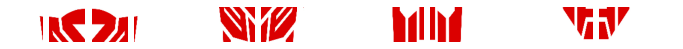

In [6]:
patches = patches.reshape(3, -1, PATCH_SIZE, PATCH_SIZE)
patches.transpose_(0, 1)

fig, ax = plt.subplots(1, 16, figsize=(12, 12))
for i in range(16):
    ax[i].imshow(to_pil_image(patches[i]))
    ax[i].axis('off')

## Putting it all together
Before sending it through to a transformer, we need to reshape our images from being `(batch_size, channels, img_height, img_width)` to `(batch_size, number_patches, pixels)` where `pixels` in the above example would be 64 x 64 x 3 = 12288 pixels.

Therefore, an example `Dataset` to read in the images would look like:

In [7]:
from torch.utils.data import Dataset

class ImageData(Dataset):
    def __init__(self, files: List[str]):
        self.files = files
        self.resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
        self.num_patches = PATCH_SIZE * PATCH_SIZE
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        img = self.resize(io.read_image(self.files[i]))
        patches = img\
                    .unfold(1, PATCH_SIZE, PATCH_SIZE)\
                    .unfold(2, PATCH_SIZE, PATCH_SIZE)
        
        patches = patches.reshape(3, -1, PATCH_SIZE, PATCH_SIZE)
        patches.transpose_(0, 1)
        
        return patches.reshape(self.num_patches, -1)

## Shameless self promotion
If you enjoyed the tutorial buy me a coffee, or better yet [buy my course](https://www.udemy.com/course/machine-learning-and-data-science-2021/?referralCode=E79228C7436D74315787) (usually 90% off).